**Abstract**

hax0r3d by aj


In [1]:
from scipy.optimize import linprog
from scipy.stats import linregress

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import random
from collections import Counter
from collections import defaultdict
from math import log2 as log


In [2]:
class LiquidityGraph:
    def __init__(self):
        # Initialize a directed graph
        self.graph = nx.DiGraph()

    def add_node(self, node):
        if node not in self.graph.nodes:
            self.graph.add_node(node, fees=0, failed=0)
        
    def add_edge(self, node1, node2, liquidity, fee=0):
        """
        Adds a directed edge from node1 to node2 with specified liquidity and fee.
        
        Parameters:
            node1: The starting node.
            node2: The ending node.
            liquidity: The liquidity of the edge.
            fee: The fee for accessing this edge from node1 to node2.
        """
        self.add_node(node1)
        self.add_node(node2)
        self.graph.add_edge(node1, node2, liquidity=liquidity, fee=fee)

    def make_payment(self, sender, receiver, amount=None):
        """
        Executes a payment from sender to receiver.
        
        Parameters:
            sender: The node initiating the payment.
            receiver: The node receiving the payment.
            amount: The amount to be transferred. If None, a random amount is selected 
                    between 0 and the maximum flow from sender to receiver.
                    
        Returns:
            bool: True if the payment was successful, False otherwise.
        """
        # Check if sender and receiver are in the graph
        if sender not in self.graph or receiver not in self.graph:
            raise ValueError("Both sender and receiver must be nodes in the graph.")

        # Calculate the maximum flow from sender to receiver
        max_flow_value, _ = nx.maximum_flow(self.graph, sender, receiver, capacity='liquidity')
        #print(max_flow_value)
        # If an amount is specified, ensure it doesn't exceed max flow
        if amount is not None:
            if amount > max_flow_value:
                #print("Payment failed: Amount exceeds max flow.")
                return False
        else:
            assert False
            if max_flow_value<1:
                #print("Payment failed: No feasible flow from ({}) to ({}) possible".format(sender,receiver))
                return False
                
            # Select a random amount between 0 and max flow if no amount is given
            amount = random.randint(1, max_flow_value)

        # Create a copy of the graph with 'cost' attribute based on fees for min-cost flow calculation
        flow_graph = nx.DiGraph()
        flow_graph.add_node(sender, demand=-amount)
        flow_graph.add_node(receiver, demand=amount)
        for u, v, data in self.graph.edges(data=True):
            if data['liquidity'] > 0:
                flow_graph.add_edge(u, v, capacity=data['liquidity'], weight=data['fee'],demand="demand")
        
        # Calculate the min-cost flow to send the `amount` from sender to receiver
        min_cost_flow_dict = nx.min_cost_flow(flow_graph)
        #print(min_cost_flow_dict)

        # Execute the payment by updating the liquidity on the edges
        for u, dests in min_cost_flow_dict.items():
            for v,flow_amount in dests.items():
                if flow_amount == 0:
                    continue
                feepaid = int(flow_amount * self.graph[u][v]["fee"] / 1e3) / 1e3
                self.graph.nodes[u]["fees"] += feepaid
                # Deduct the flow amount from u -> v
                self.graph[u][v]['liquidity'] -= flow_amount
                # Increase the reverse edge v -> u liquidity by flow amount
                if self.graph.has_edge(v, u):
                    self.graph[v][u]['liquidity'] += flow_amount
                else:
                    print("revedge", v, u)
                    # If the reverse edge doesn't exist, create it with initial liquidity of flow_amount
                    self.graph.add_edge(v, u, liquidity=flow_amount, fee=self.graph[u][v]['fee'])
            
        # XXX doesn't actually pay the fees, just uses them as a cost function when choosing a route
        
        #print(f"Payment of {amount} from {sender} to {receiver} was successful.")
        return True



## Case Study: Channel Depletion in a Network with net 0 flow

Historically there where two main explainations why we observe depleted channels.

1. The Lightning Network protocol only supported that the person opening a channel to provide liquidity on their end and the information about liquidity in the network was not known. Given that the network was in its bootstrapping phase it seemed natural to assume that the high fraction of depleted channels was an artifact of those two facts
2. Over time Swapping services and dual funded channel protocols have been established also more economic actors joined the network. Never we continue to see depletion of channels. The dominant explaination is that [the network consists of source and sink nodes and that money constanly flows from sources to sinks](https://pubsonline.informs.org/doi/10.1287/mnsc.2023.03872#:~:text=LN%20channels%20enable%20payments%20between,flows%20but%20impose%20different%20costs.) depleting the channels connecting those. This is somewhat supported with on chain forensics.

In this case study we provide a small example network that illustrates that **depletion occurs even in a circular economy where the total net flow of all nodes is 0** (id est: no source and sink nodes exist when all successfull conducted payments are aggregated) 

In [3]:
# Create a figure
def draw_small_network(H):
    plt.figure(figsize=(18, 16))

    pos = {
        "Carol": (0, 1),   # Top
        "Alice": (0, -1),  # Bottom
        "Bob": (1, 0),    # Right
        "David": (-1, 0)    # Left
    }

    labels = {}
    caps = {}
    edge_colors = []  # List to store edge colors

    for edge in H.edges():
        u, v = edge
        # Liquidity and fee information for both directions
        liquidity_uv = H[u][v]['liquidity']
        fee_uv = H[u][v]['fee']
    
        liquidity_vu = H[v][u]['liquidity'] if H.has_edge(v, u) else 0
        fee_vu = H[v][u]['fee'] if H.has_edge(v, u) else 0
    
        # Calculate total capacity
        capacity = liquidity_uv + liquidity_vu
    
        # Add labels for edge capacity
        if u < v:  # To avoid duplicate labels for undirected edges
            caps[(u, v)] = f"Cap: {capacity} sats"
            
        # Determine the edge color
        if liquidity_uv <= 50:
            edge_colors.append("red")  # depleted
        else:
            edge_colors.append("black")  # Does not meet the criteria

        # Add usage and fee labels
        labels[(u, v)] = f"{liquidity_uv} sats\nPPM: {fee_uv}"
 
    nodelabels = {}
    for node in H.nodes():
        fees = H.nodes[node]["fees"]
        if fees == 0:
            nodelabels[node] = node
        elif fees > 5:
            nodelabels[node] = f"{node}\nfees: {fees:.1f}"
        else:
            nodelabels[node] = f"{node}\nfees: {fees:.3f}"
        failed = H.nodes[node]["failed"]
        if failed > 0:
            nodelabels[node] += f"\nfailed: {failed}"
            
    # Draw nodes and edges
    # Add labels for nodes
    nx.draw_networkx_nodes(H, pos, node_size=6000, node_color='lightblue')
    nx.draw_networkx_labels(H, pos, labels=nodelabels, font_size=16, font_color="black")

    nx.draw_networkx_edges(
        H, pos, width=5.0, arrowsize=60, edge_color=edge_colors, connectionstyle="arc3,rad=0.15",
        min_source_margin=0, min_target_margin=50
    )

    # Draw edge labels
    nx.draw_networkx_edge_labels(
        H, pos, edge_labels=caps, font_size=20, 
        bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5),
        label_pos=0.5, rotate=True
    )

    nx.draw_networkx_edge_labels(
        H, pos, edge_labels=labels, font_size=15, 
        bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5), 
        label_pos=0.75, rotate=True
    )

    plt.tight_layout()
    plt.show()
    


In [17]:
def simulate_payments_with_wealth(example, *, num_payments=100, amount=1, ets=None, wts=None):
    """
    Simulates random payments between nodes and records edge liquidity and wealth over time.

    Parameters:
        example (LiquidityGraph): The liquidity graph object.
        num_payments (int): Number of random payments to simulate.

    Returns:
        tuple: A tuple containing:
            - edge_time_series (dict): A dictionary where keys are edges (u, v), 
                                       and values are lists of liquidity values over time.
            - wealth_time_series (dict): A dictionary where keys are nodes, 
                                         and values are lists of wealth values over time.
    """
    # Initialize time series dictionaries
    edge_time_series = {edge: [] for edge in example.graph.edges if edge[0]<edge[1]} if ets is None else ets
    wealth_time_series = {node: [] for node in example.graph.nodes} if wts is None else wts    

    # Nodes in the graph
    nodes = list(example.graph.nodes)
    total_liquidity = sum(example.graph[u][v]['liquidity'] for u,v in example.graph.edges())
    # Simulate payments
    for _ in range(num_payments):
        # Randomly select source and target nodes
        source, target = random.sample(nodes, 2)

        if not example.make_payment(source, target, amount=amount):
            example.graph.nodes[source]["failed"] += amount
        
        # Record the current liquidity of all edges
        for edge in example.graph.edges:
            u,v = edge
            if u>v:
                continue
            uv = example.graph[edge[0]][edge[1]]['liquidity']
            vu = example.graph[edge[1]][edge[0]]['liquidity']
            edge_time_series[edge].append(uv/(uv+vu))

        # Record the current wealth of all nodes
        for node in example.graph.nodes:
            wealth = sum(
                example.graph[node][neighbor]['liquidity'] for neighbor in example.graph.neighbors(node)
            )
            wealth_time_series[node].append(wealth/total_liquidity)

    return edge_time_series, wealth_time_series


In [18]:
def plot_liquidity_time_series(time_series):
    """
    Plots the liquidity time series for every edge in the network.
    
    Parameters:
        time_series (dict): A dictionary where keys are edges (u, v), and values are lists of 
                            liquidity values over time.
    """
    num_edges = len(time_series)
    cols = 1  # Number of columns in the subplot grid
    rows = math.ceil(num_edges / cols)  # Number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows*2 ), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes to iterate over them easily

    for idx, (edge, series) in enumerate(time_series.items()):
        axes[idx].plot(range(len(series)), series, label=f"Edge {edge}")
        axes[idx].set_title(f"Liquidity Time Series for Edge {edge}")
        axes[idx].set_xlabel("Time")
        axes[idx].grid()
        axes[idx].set_ylabel("Liquidity")
        axes[idx].legend()
        axes[idx].set_ylim(0,1)


    # Hide any unused subplots
    for ax in axes[num_edges:]:
        ax.set_visible(False)

    plt.show()

    plt.figure(figsize=(12,9))
    plt.title("Liquidity time series for various channels")
    
    for idx, (edge, series) in enumerate(time_series.items()):
        plt.plot(range(len(series)), series, label=f"Edge {edge}")
    plt.xlabel("Time")
    plt.grid()
    plt.ylabel("Liquidity")
    plt.legend()



In [19]:
def plot_wealth_time_series(time_series,normed=False):
    """
    Plots the liquidity time series for every edge in the network.
    
    Parameters:
        time_series (dict): A dictionary where keys are edges (u, v), and values are lists of 
                            liquidity values over time.
    """
    num_edges = len(time_series)
    cols = 1  # Number of columns in the subplot grid
    rows = math.ceil(num_edges / cols)  # Number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows*2 ), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes to iterate over them easily
    titsuf = " (full y-axis)" if normed else ""
    for idx, (edge, series) in enumerate(time_series.items()):
        axes[idx].plot(range(len(series)), series, label=f"Node {edge}")
        axes[idx].set_title(f"Wealth time series for {edge}" + titsuf)
        if normed:
            axes[idx].set_ylim(0,1)
        axes[idx].set_xlabel("Time")
        axes[idx].set_ylabel("wealth")
        axes[idx].legend()

    # Hide any unused subplots
    for ax in axes[num_edges:]:
        ax.set_visible(False)

    plt.show()


In [20]:
def new_example():
    example = LiquidityGraph()
    example.add_edge("Alice", "Bob", 2000, 100)
    example.add_edge("Bob", "Carol", 2000, 100)
    example.add_edge("Carol", "David", 2000, 100)
    example.add_edge("David", "Alice", 2000, 250)
    example.add_edge("David", "Carol", 2000, 200)
    example.add_edge("Carol", "Bob", 2000, 300)
    example.add_edge("Bob", "Alice", 2000, 400)
    example.add_edge("Alice", "David", 2000, 300)
    example.add_edge("Alice", "Carol", 4000, 250)
    example.add_edge("Carol", "Alice", 4000, 0)
    return example

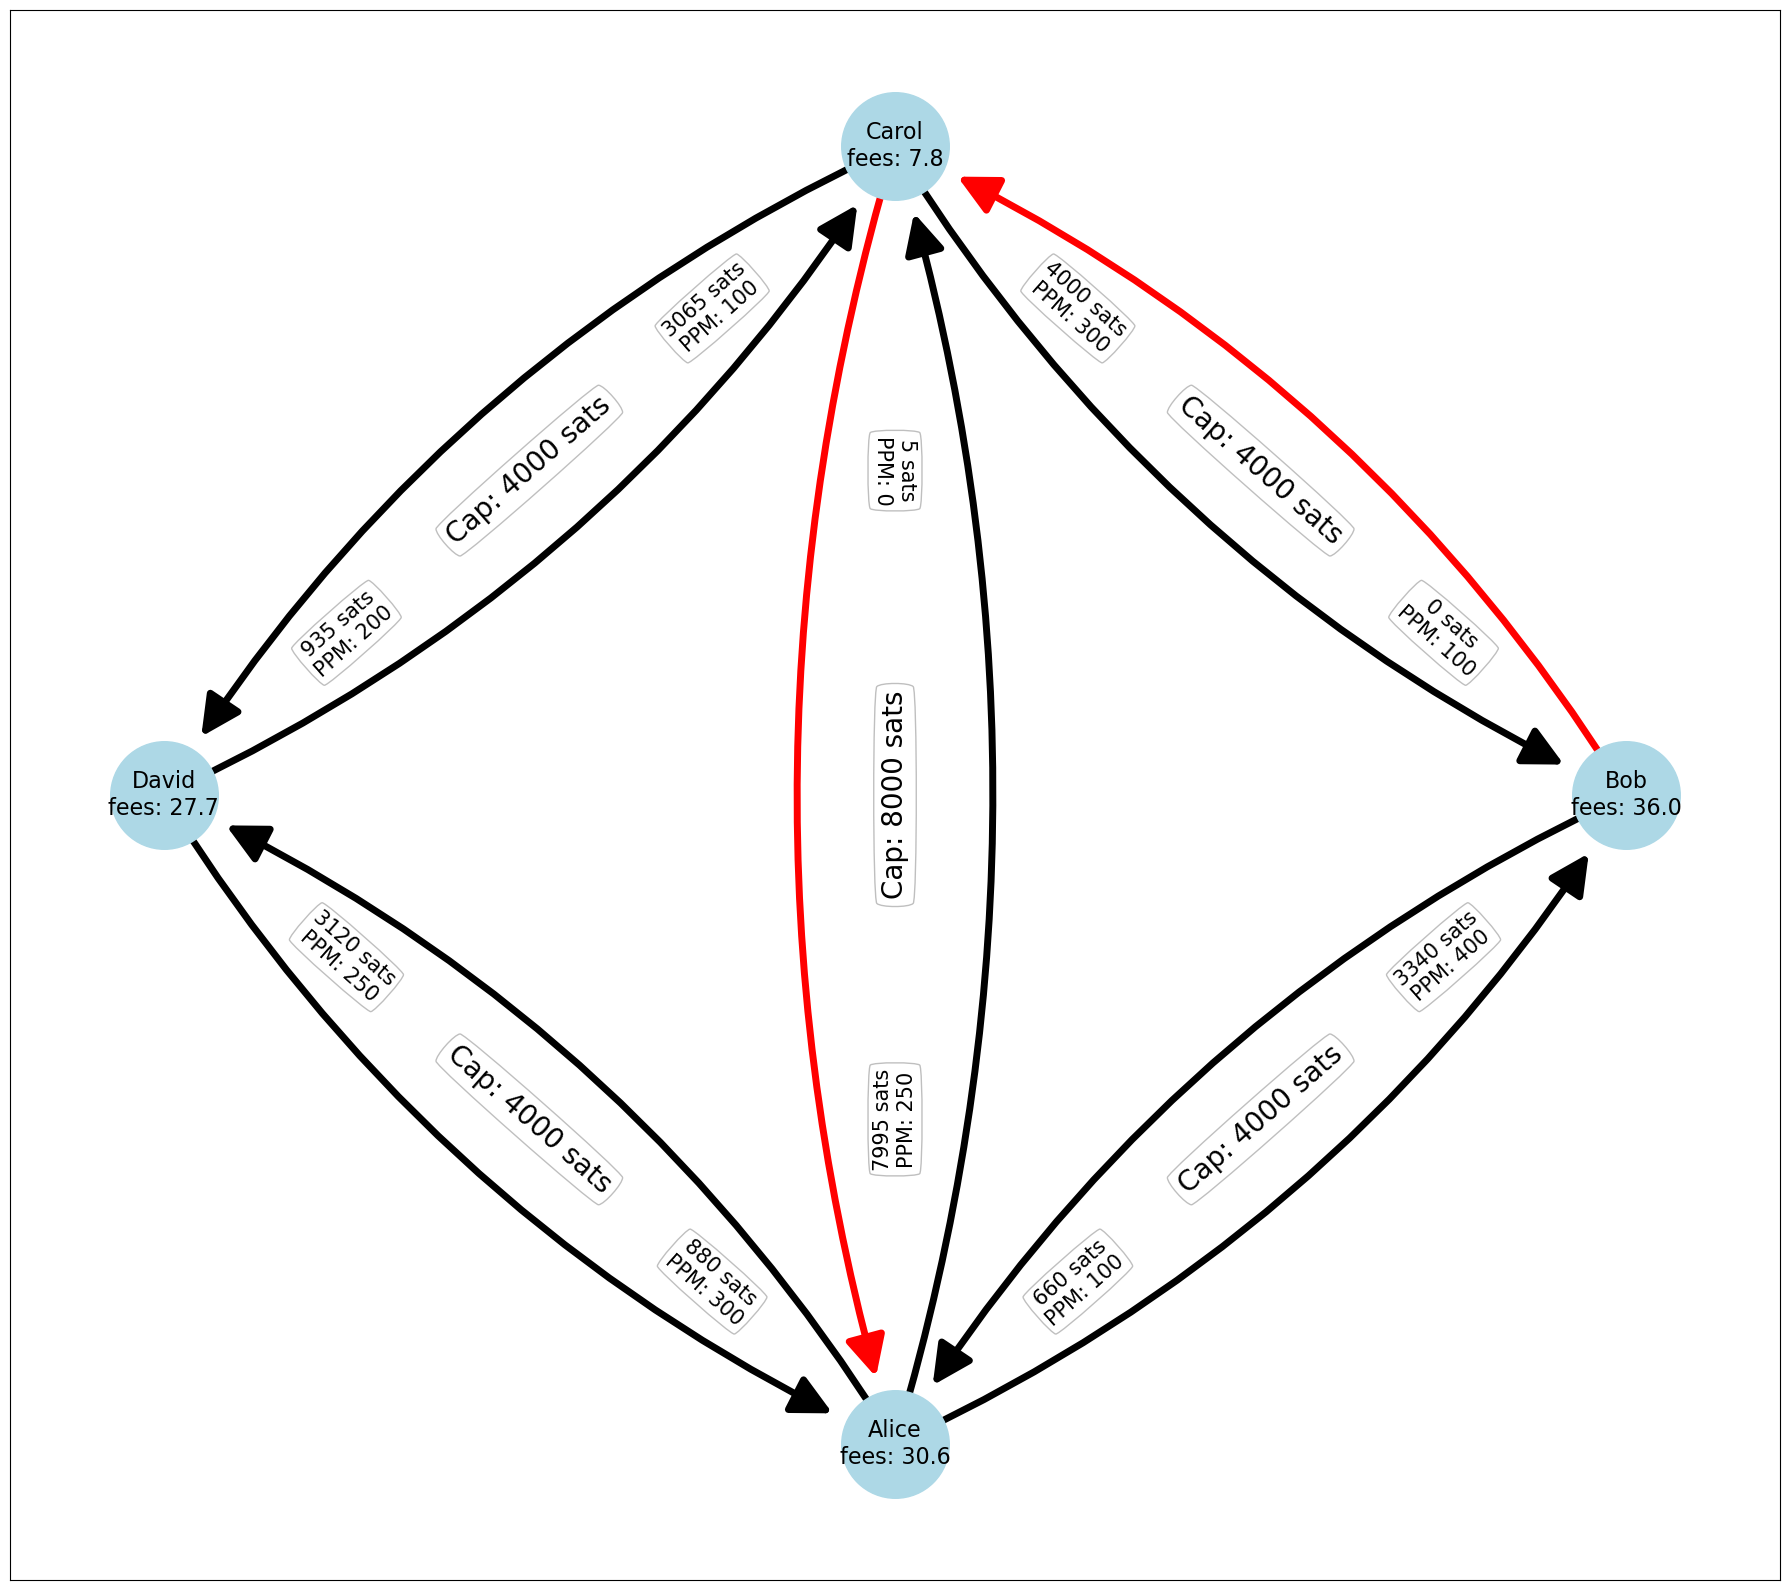

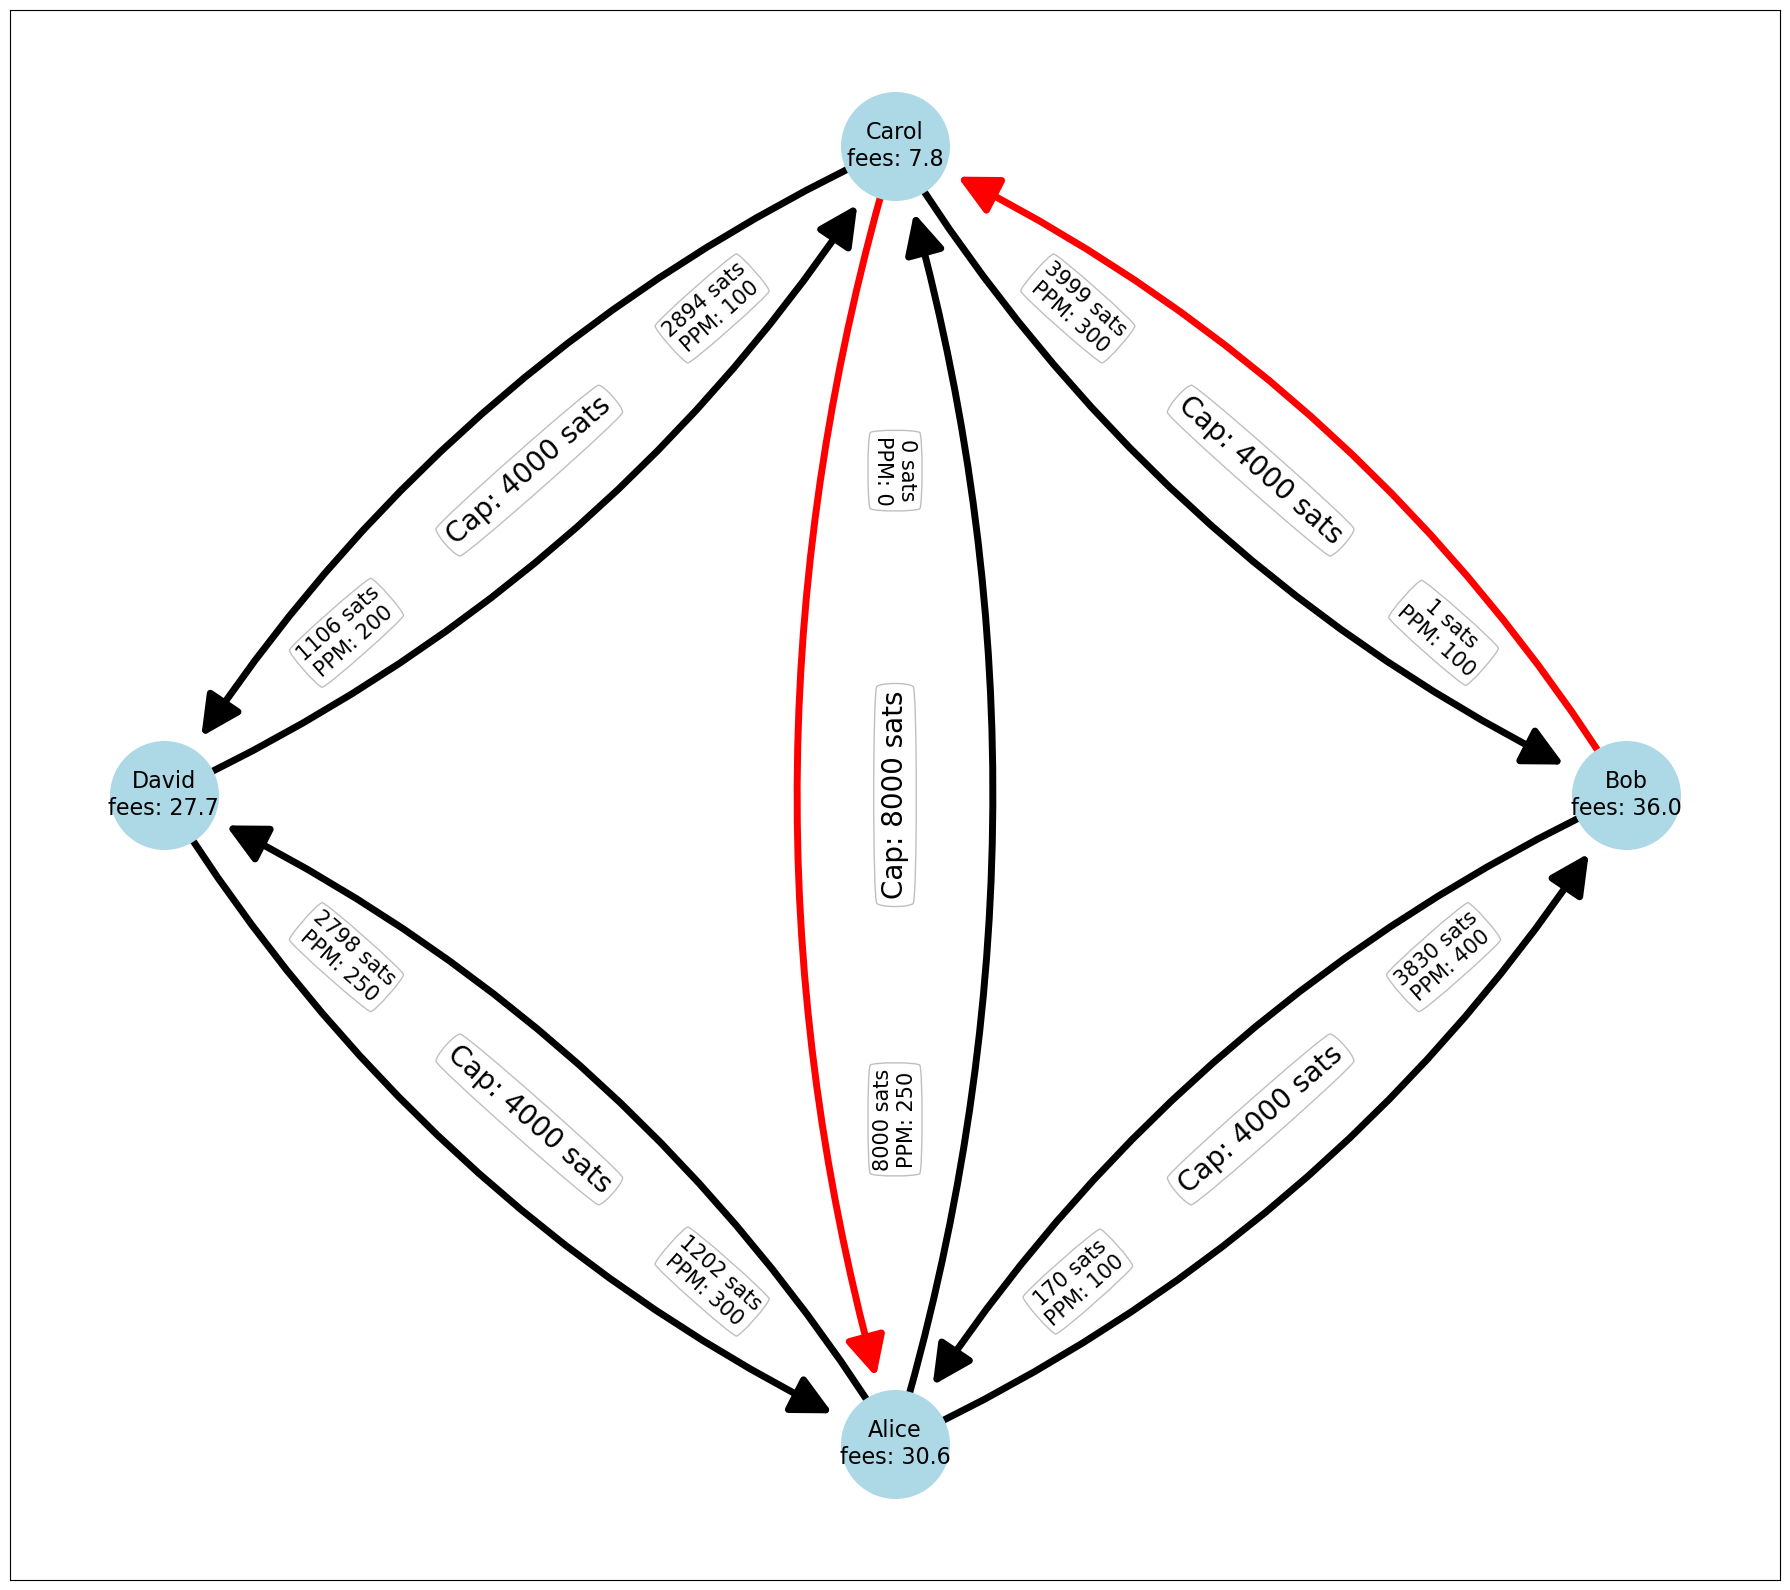

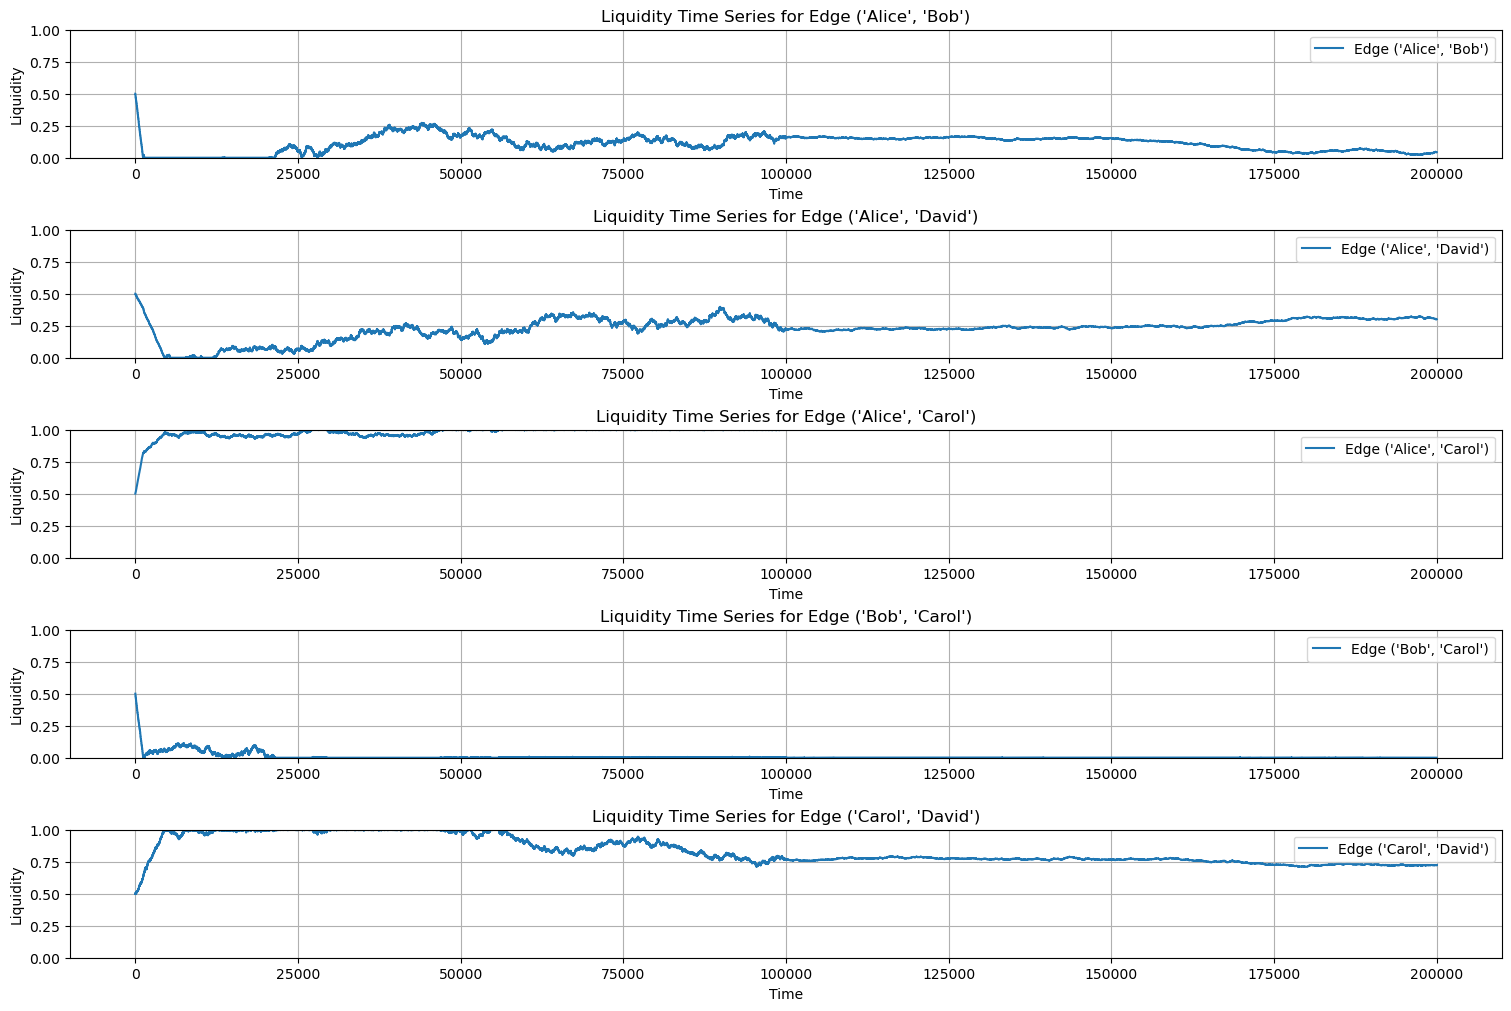

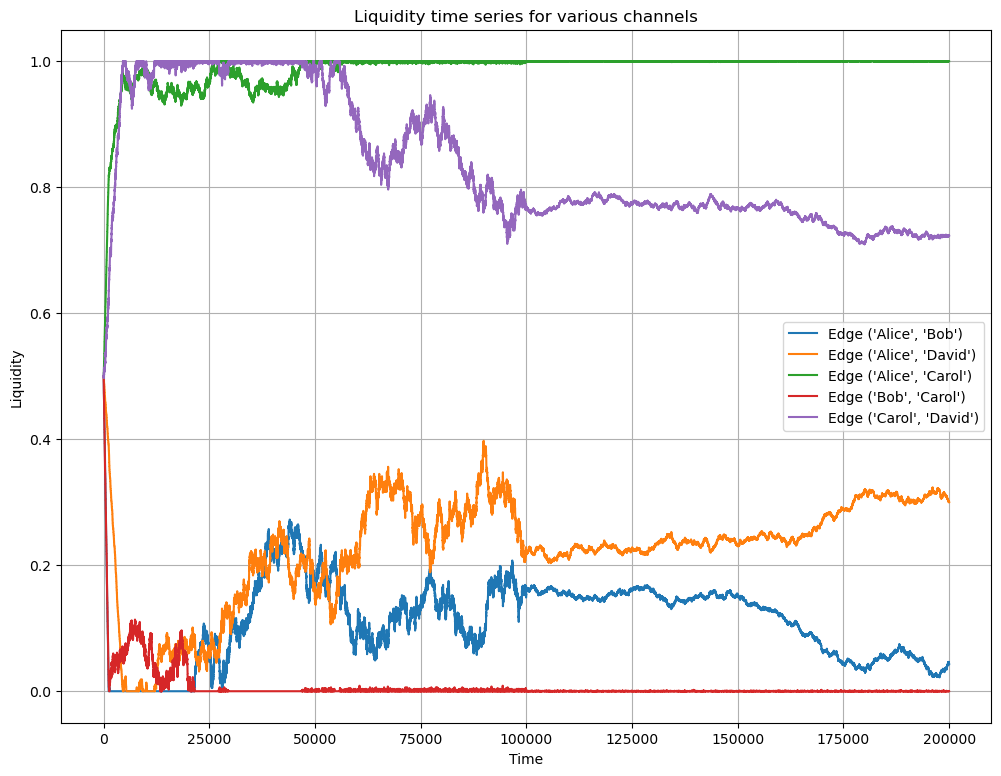

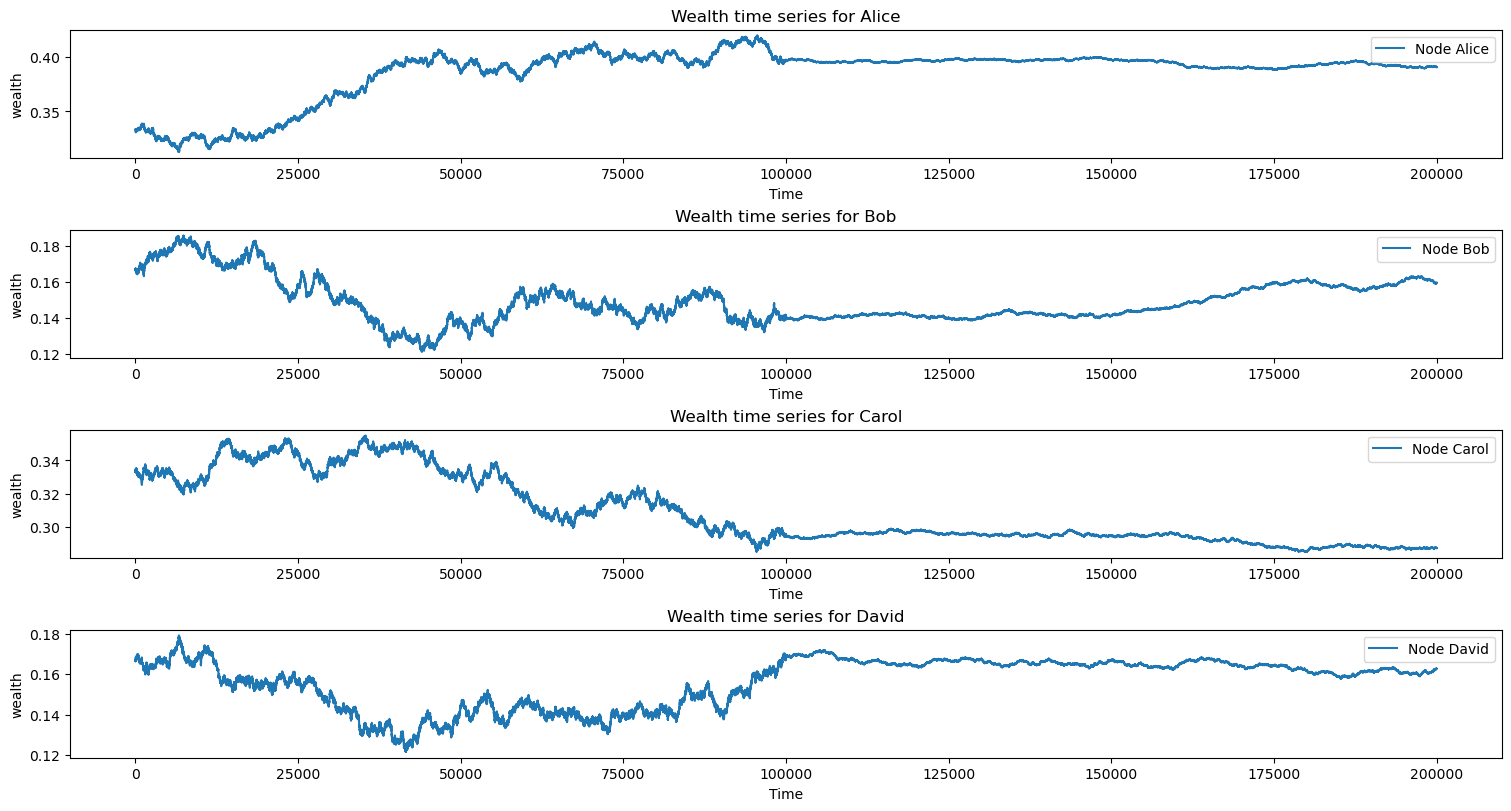

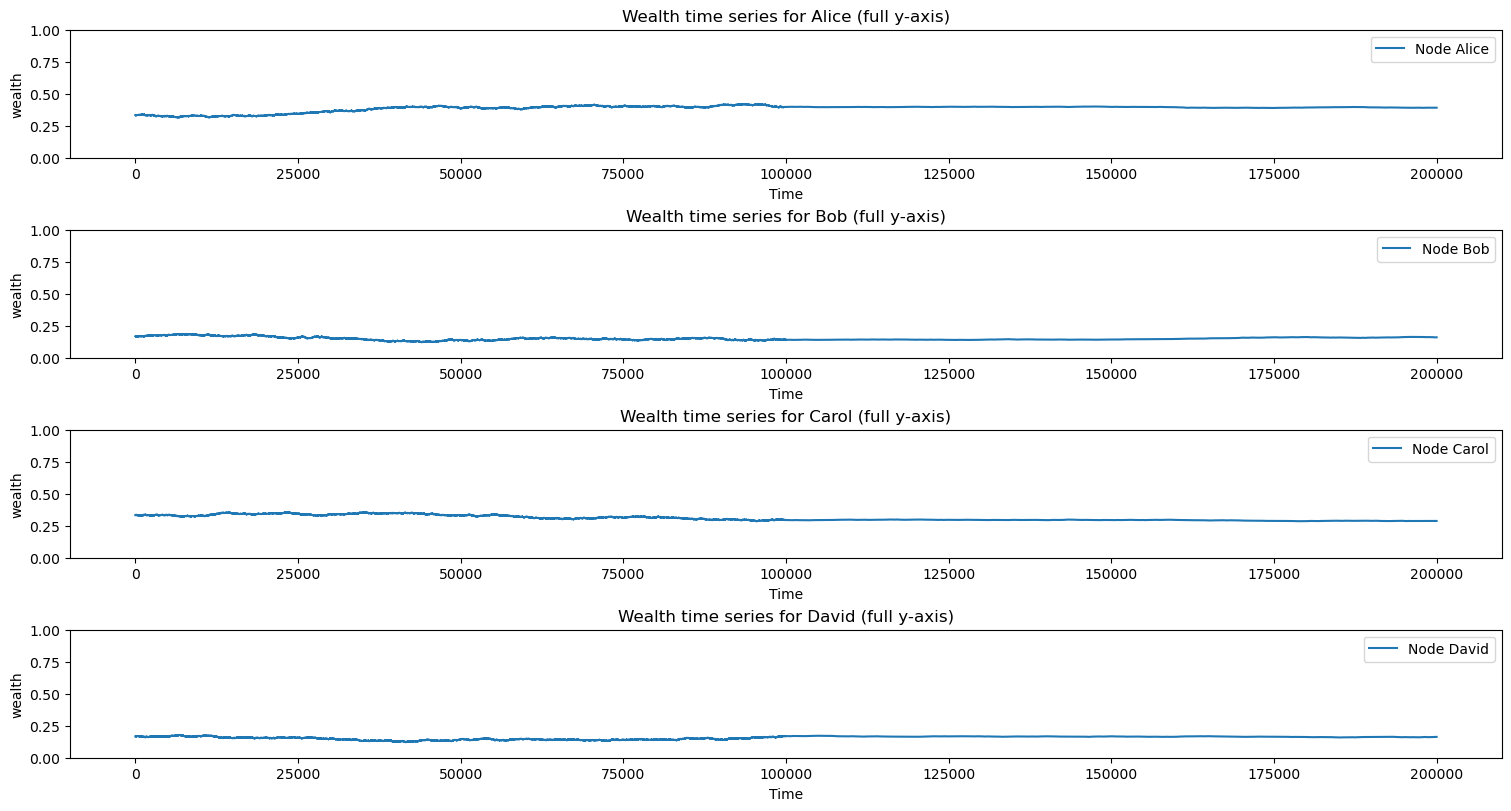

In [21]:
example = new_example()
ts,w_ts = simulate_payments_with_wealth(example, num_payments=100000, amount=5)
draw_small_network(example.graph)
simulate_payments_with_wealth(example, num_payments=100000, amount=1, ets=ts, wts=w_ts)
draw_small_network(example.graph)

plot_liquidity_time_series(ts)

plot_wealth_time_series(w_ts)
plot_wealth_time_series(w_ts,True)

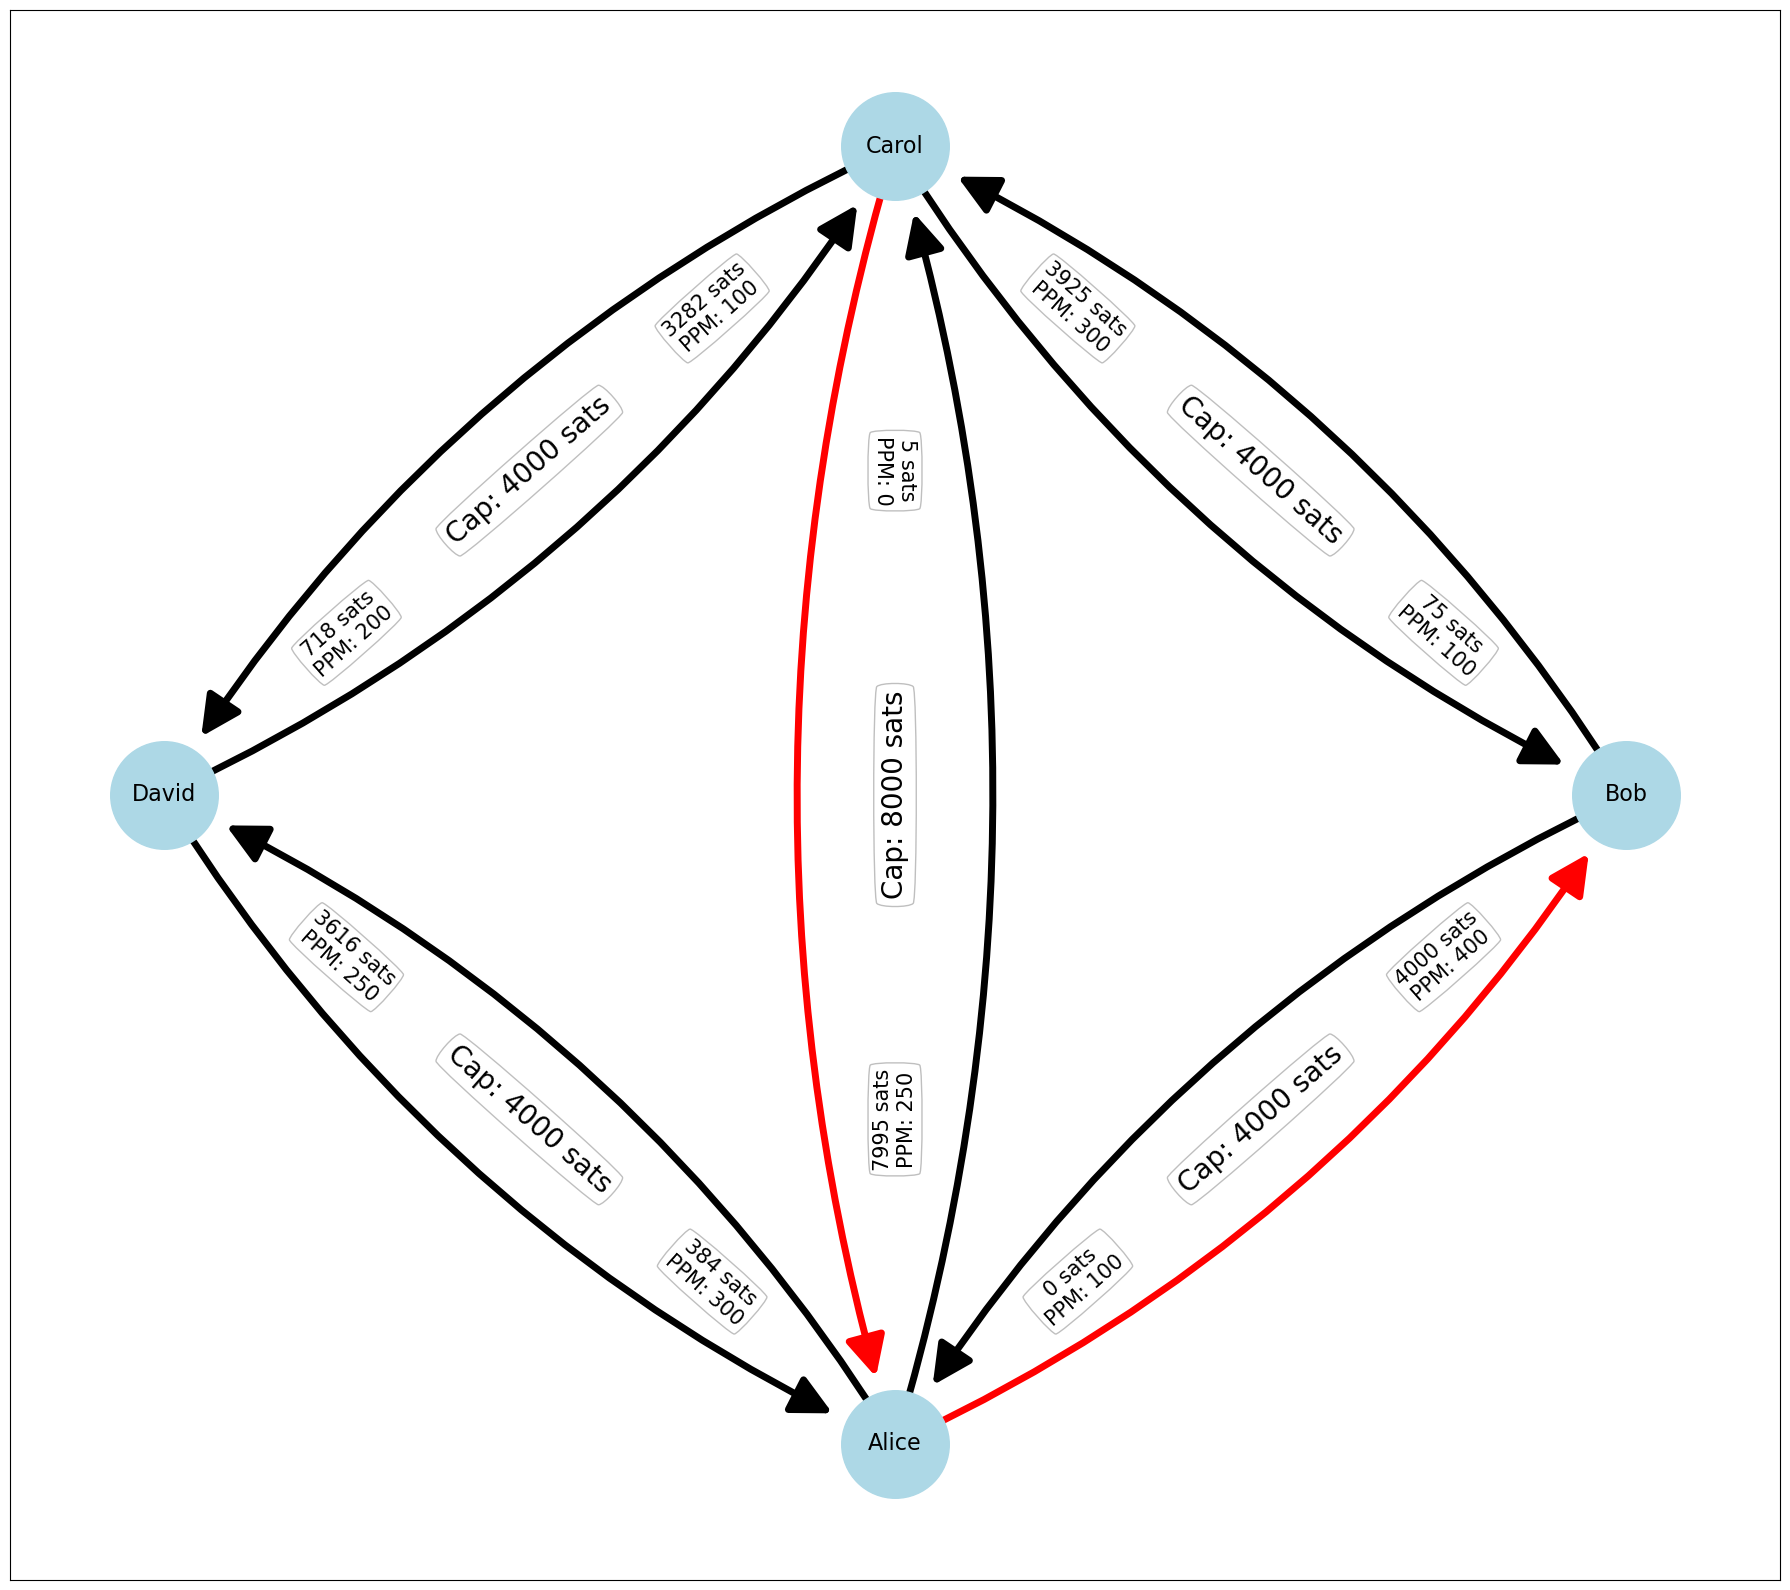

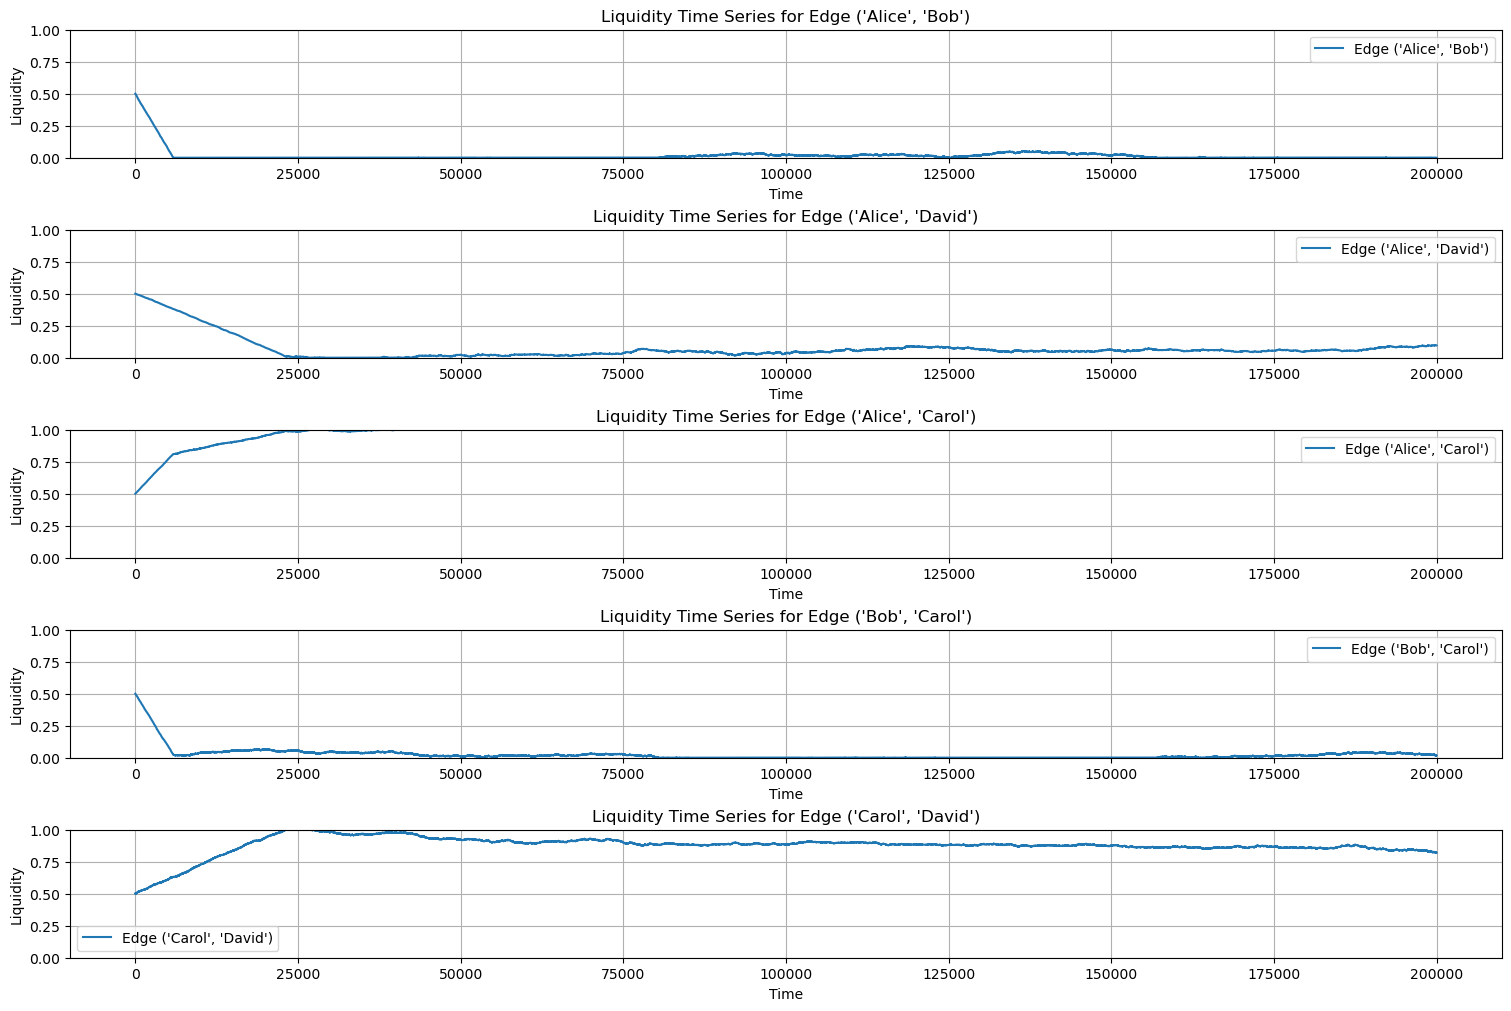

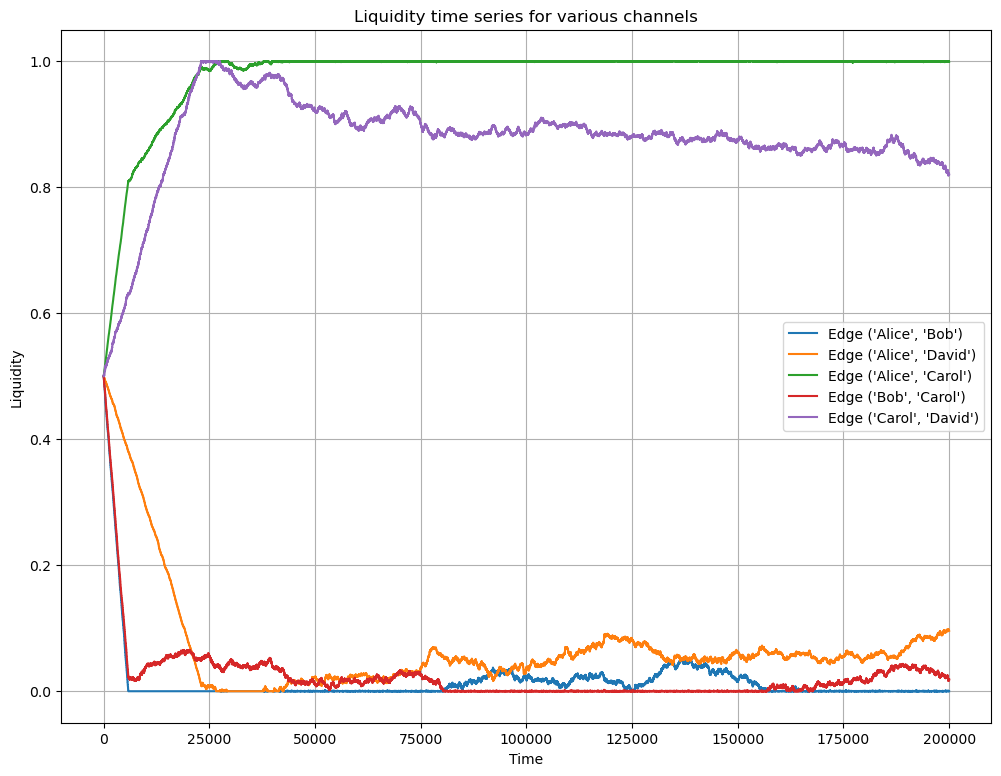

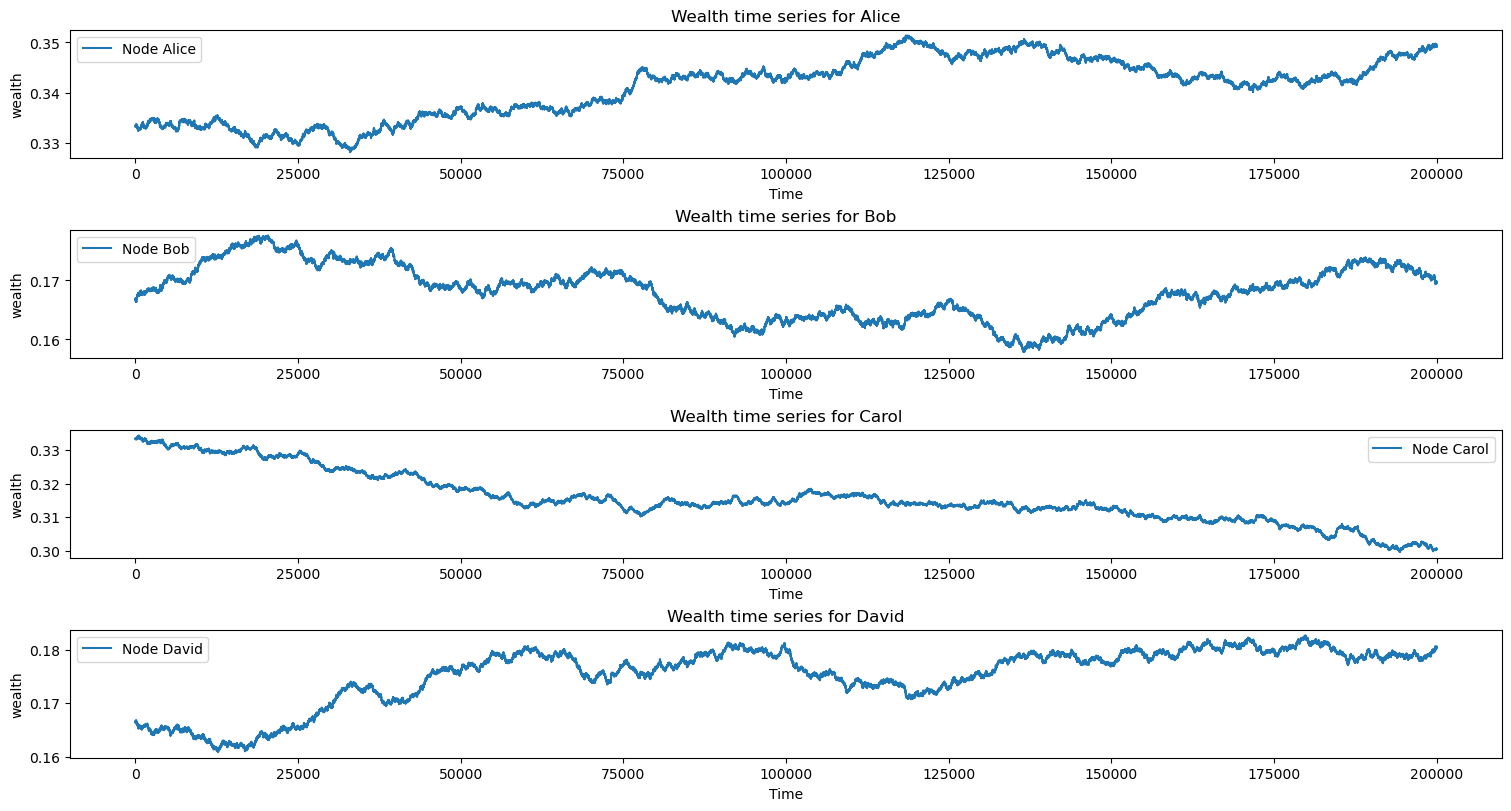

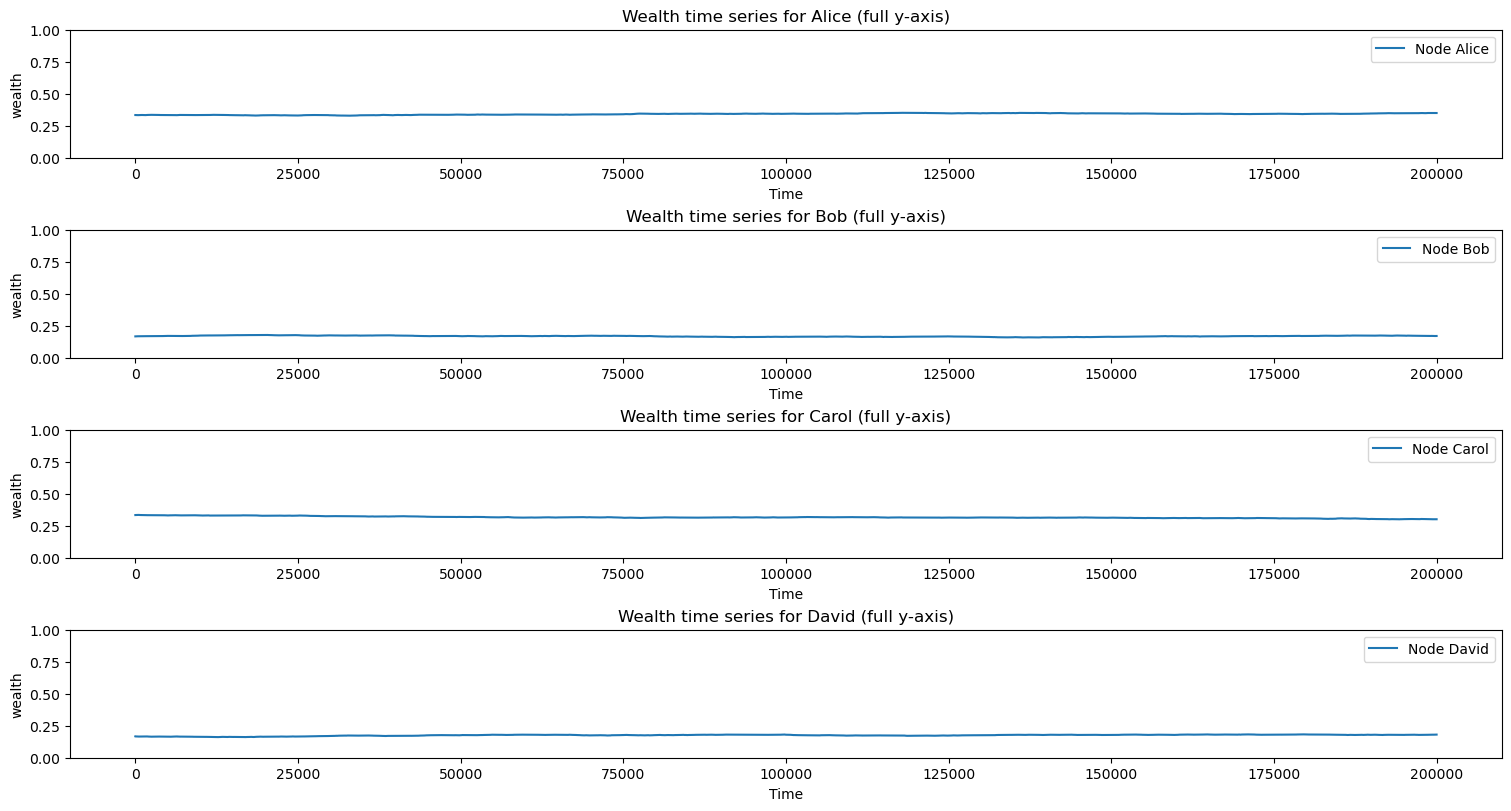

In [22]:
example = new_example()
ts,w_ts = simulate_payments_with_wealth(example, num_payments=200000, amount=1)
draw_small_network(example.graph)

plot_liquidity_time_series(ts)

plot_wealth_time_series(w_ts)
plot_wealth_time_series(w_ts,True)